# Inicialização

In [20]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import seaborn as sns
from snscrape.base import ScraperException
import snscrape.modules.twitter as sntwitter
from tqdm import tqdm

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option("display.max_columns", 30)
pd.options.display.float_format = "{:,.2f}".format


In [2]:
dataset_path = "../data/raw/"
dataset_name = "consulta_cand_2022_SP.csv"
cand_sp_df = pd.read_csv(f"{dataset_path}{dataset_name}", sep=";")
print(cand_sp_df.shape)
cand_sp_df.info()


(3659, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     3659 non-null   object 
 1   HH_GERACAO                     3659 non-null   object 
 2   ANO_ELEICAO                    3659 non-null   int64  
 3   CD_TIPO_ELEICAO                3659 non-null   int64  
 4   NM_TIPO_ELEICAO                3659 non-null   object 
 5   NR_TURNO                       3659 non-null   int64  
 6   CD_ELEICAO                     3659 non-null   int64  
 7   DS_ELEICAO                     3659 non-null   object 
 8   DT_ELEICAO                     3659 non-null   object 
 9   TP_ABRANGENCIA                 3659 non-null   object 
 10  SG_UF                          3659 non-null   object 
 11  SG_UE                          3659 non-null   object 
 12  NM_UE                          3659 n

In [3]:
# Carregando dataset com os dados de redes sociais dos candidatos de SP nas eleições de 2022
rs_df = pd.read_csv(f"{dataset_path}rede_social_candidato_2022_SP.csv", sep=";")
print(rs_df.shape)
rs_df.info()


(6735, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6735 entries, 0 to 6734
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DT_GERACAO       6735 non-null   object
 1   HH_GERACAO       6735 non-null   object
 2   AA_ELEICAO       6735 non-null   int64 
 3   SG_UF            6735 non-null   object
 4   CD_TIPO_ELEICAO  6735 non-null   int64 
 5   NM_TIPO_ELEICAO  6735 non-null   object
 6   CD_ELEICAO       6735 non-null   int64 
 7   DS_ELEICAO       6735 non-null   object
 8   SQ_CANDIDATO     6735 non-null   int64 
 9   NR_ORDEM         6735 non-null   int64 
 10  DS_URL           6735 non-null   object
dtypes: int64(5), object(6)
memory usage: 578.9+ KB


## Juntando os datasets

In [4]:
# Filtrando somente candidatos com conta no Twitter
rs_twitter_df = rs_df[rs_df.DS_URL.str.contains("twitter", case=False)]
print(rs_twitter_df.shape)


(624, 11)


In [5]:
# Juntando as duas bases
df = pd.merge(
    cand_sp_df, rs_twitter_df[["SQ_CANDIDATO", "DS_URL"]], on="SQ_CANDIDATO", how="left"
)
df.shape


(3682, 72)

In [6]:
# Filtrando somente candidatos a deputado estadual
candidates_df = df.loc[(df["DS_CARGO"] == "DEPUTADO ESTADUAL")]

print(candidates_df.shape)


(2068, 72)


# Checagem dos dados

## Dados duplicados

In [7]:
# Vamos checar os candidatos duplicados
duplicated_candidates_id = (
    (candidates_df.SQ_CANDIDATO.value_counts() > 1).loc[lambda x: x == True].index
)
candidates_df[candidates_df["SQ_CANDIDATO"].isin(duplicated_candidates_id)][
    ["SQ_CANDIDATO", "DS_URL"]
]


,SQ_CANDIDATO,DS_URL
179,250001643640,https://twitter.com/DrMarcioAurelio
180,250001643640,https://twitter.com/DrMarcioAurelio
181,250001643640,https://twitter.com/raiztrabalhista
578,250001619366,https://twitter.com/MarinadaMantiq1?t=8vFxK3Hx...
579,250001619366,https://twitter.com/Mantiqueira18?t=hLpMVYYVZ0...
885,250001611799,https://twitter.com/depeniotatto
886,250001611799,https://www.twitter.com/eniotatto13114
2344,250001620657,https://www.twitter.com/FabioAdonis
2345,250001620657,https://twitter.com/fabiojabaDGtal?t=45hkTz2X4...
2688,250001611457,https://twitter.com/alefrota77


In [8]:
# Vamos checar estas contas no Twitter
drop_list = []

# A conta DrMarcioAurelio está repetida, portanto vamos remover uma das linhas
drop_list.append(180)

# A conta raiztrabalhista é de um coletivo político e não do candidato
drop_list.append(181)

# A conta Mantiqueira18 é de um coletivo político e não do candidato
drop_list.append(579)

# A conta eniotatto13114 não existe mais
drop_list.append(886)

# A conta FabioAdonis é pessoal e não posta desde 2017
drop_list.append(2344)

# A conta alefrota77 não existe mais
drop_list.append(2688)

# A conta GeraldóNobrega não existe mais
drop_list.append(2784)

# A conta rodrigo_pt13 não tem nenhum tweet
drop_list.append(3442)

# A conta valverdemogi possui apenas um tweet de 2021
drop_list.append(3443)

In [9]:
# Removendo as contas acima
candidates_df = candidates_df.drop(drop_list)

# Exploração dos dados

In [10]:
# Vamos criar diferentes segmentações, para facilitar a comparação de diversidade
elected_values = ["ELEITO POR QP", "ELEITO POR MÉDIA", "ELEITO"]

# Deputados estaduais eleitos
elected_df = candidates_df.loc[(candidates_df["DS_SIT_TOT_TURNO"].isin(elected_values))]

# Deputados estaduais eleitos com perfil no Twitter
twitter_df = elected_df.loc[(elected_df["DS_URL"].notna())]

print(candidates_df.shape)
print(elected_df.shape)
print(twitter_df.shape)


(2059, 72)
(94, 72)
(49, 72)


### Analisando a diversidade

In [11]:
print("Candidatos a deputado estadual")
print(candidates_df.groupby(["DS_GENERO", "DS_COR_RACA"]).size())
print()
print("Candidatos a deputado estadual eleitos")
print(elected_df.groupby(["DS_GENERO", "DS_COR_RACA"]).size())
print()
print("Candidatos a deputado estadual eleitos com conta no Twitter")
print(twitter_df.groupby(["DS_GENERO", "DS_COR_RACA"]).size())
print()


Candidatos a deputado estadual
DS_GENERO       DS_COR_RACA   
FEMININO        AMARELA             8
                BRANCA            419
                INDÍGENA            2
                PARDA             115
                PRETA             132
MASCULINO       AMARELA            11
                BRANCA            906
                INDÍGENA            4
                NÃO INFORMADO       1
                PARDA             318
                PRETA             142
NÃO DIVULGÁVEL  NÃO DIVULGÁVEL      1
dtype: int64

Candidatos a deputado estadual eleitos
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         19
           PARDA           1
           PRETA           5
MASCULINO  BRANCA         57
           PARDA           8
           PRETA           4
dtype: int64

Candidatos a deputado estadual eleitos com conta no Twitter
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         11
           PARDA           1
           PRETA           4
MASCULINO  BRANCA         31
           PARDA   

Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


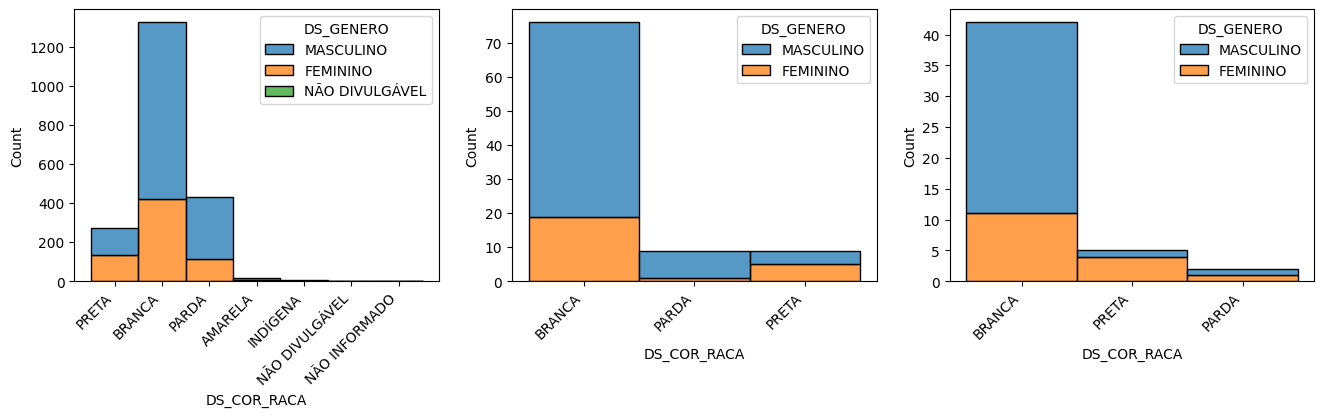

In [12]:
# Visualizando a distribuição de gênero em raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue="DS_GENERO",
    x="DS_COR_RACA",
    multiple="stack",
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue="DS_GENERO",
    x="DS_COR_RACA",
    multiple="stack",
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue="DS_GENERO",
    x="DS_COR_RACA",
    multiple="stack",
    ax=ax[0][2],
)

print(
    "Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter"
)
plt.show()


Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


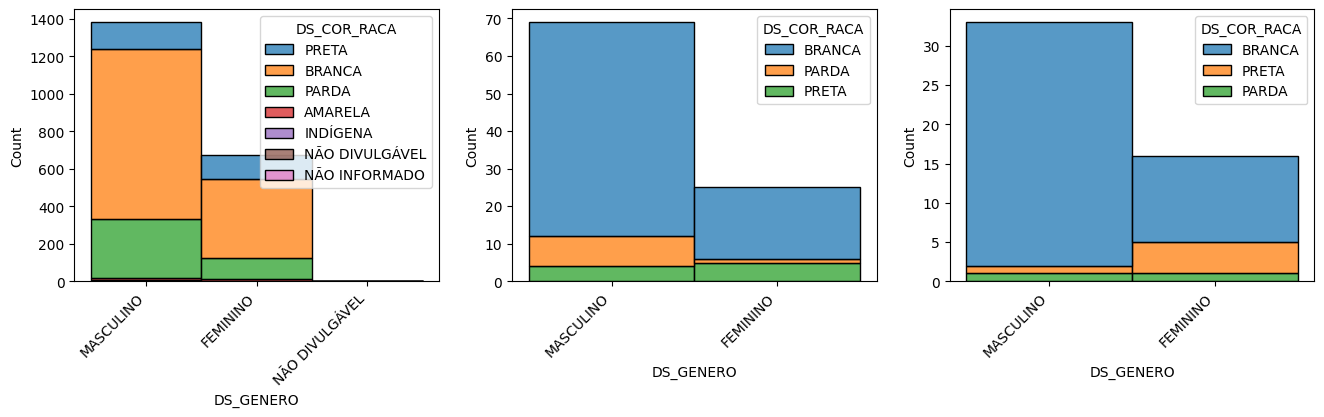

In [13]:
# Visualizando a distribuição de gênero e raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue="DS_COR_RACA",
    x="DS_GENERO",
    multiple="stack",
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue="DS_COR_RACA",
    x="DS_GENERO",
    multiple="stack",
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue="DS_COR_RACA",
    x="DS_GENERO",
    multiple="stack",
    ax=ax[0][2],
)

print(
    "Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter"
)
plt.show()


# Extração de dados do Twitter

## Dados das contas

In [14]:
# Vamos listar as contas no twitter dos deputados estaduais eleitos
twitter_df.DS_URL

22                          https://www.twitter/dreltonjr
232              https://twitter.com/EdianeMariaMTST?s=09
276     https://twitter.com/fabibbolsonaro?s=21&t=yq90...
318                      https://twitter.com/delegadoolim
367     https://www.twitter.com/https://twitter.com/le...
391     https://twitter.com/bethsahao?ref_src=twsrc%5E...
427                          https://twitter.com/sppretas
458                    https://www.twitter.com/tomeabduch
459                     https://twitter.com/prcarloscezar
490                        https://twitter.com/majormecca
514                      https://twitter.com/valbolsonaro
560                      https://twitter.com/zimbaldirafa
599                    https://twitter.com/CarlosGiannazi
660              https://twitter.com/tenente_coimbra?s=11
690                   https://twitter.com/rafaelsaraivasp
741                    https://twitter.com/BrunoZambelli3
742                      https://twitter.com/LFTeixeira13
810           

In [15]:
# Como precisamos somente do username, precisamos aplicar uma função
def get_twitter_username(link):
    link = link.rstrip("/")
    username = link.split("/")[-1]
    username = username.split("?")[0]
    return username.lower()


twitter_df["TW_USER"] = twitter_df.DS_URL.apply(get_twitter_username)
twitter_df["TW_USER"].describe()


/tmp/ipykernel_6923/2390309642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)


count            49
unique           49
top       dreltonjr
freq              1
Name: TW_USER, dtype: object

In [16]:
%%time
# Vamos raspar os dados numéricos de cada uma das contas do Twitter
usernames = list(twitter_df['TW_USER'])

user_data = {}
for i, username in enumerate(usernames):
    try:
        last_tweet = next(sntwitter.TwitterProfileScraper(username).get_items())
        user_data[username] = {
            'followersCount': last_tweet.user.followersCount,
            'friendsCount': last_tweet.user.friendsCount,
            'statusesCount': last_tweet.user.statusesCount,
            'favouritesCount': last_tweet.user.favouritesCount,
            'listedCount': last_tweet.user.listedCount,
            'mediaCount': last_tweet.user.mediaCount,
        }
        print(f'{i+1}/{len(usernames)} {username}: {user_data[username]}')
    except Exception as e:
        print(f'{i+1}/{len(usernames)} {username}: Erro {e}')
        user_data[username] = {
            'followersCount': 0,
            'friendsCount': 0,
            'statusesCount': 0,
            'favouritesCount': 0,
            'listedCount': 0,
            'mediaCount': 0,
        }

1/49 dreltonjr: {'followersCount': 875, 'friendsCount': 461, 'statusesCount': 746, 'favouritesCount': 304, 'listedCount': 2, 'mediaCount': 480}
2/49 edianemariamtst: {'followersCount': 14692, 'friendsCount': 250, 'statusesCount': 3883, 'favouritesCount': 3294, 'listedCount': 41, 'mediaCount': 689}
3/49 fabibbolsonaro: {'followersCount': 15497, 'friendsCount': 7072, 'statusesCount': 102, 'favouritesCount': 500, 'listedCount': 5, 'mediaCount': 41}
4/49 delegadoolim: {'followersCount': 3004, 'friendsCount': 0, 'statusesCount': 1924, 'favouritesCount': 233, 'listedCount': 37, 'mediaCount': 465}
5/49 leosiqueirabr: {'followersCount': 56635, 'friendsCount': 1099, 'statusesCount': 9042, 'favouritesCount': 4964, 'listedCount': 362, 'mediaCount': 1019}
6/49 bethsahao: {'followersCount': 2768, 'friendsCount': 1574, 'statusesCount': 9681, 'favouritesCount': 3872, 'listedCount': 70, 'mediaCount': 545}
7/49 sppretas: {'followersCount': 1800, 'friendsCount': 18, 'statusesCount': 283, 'favouritesCoun

Empty response


8/49 tomeabduch: Erro Could not resolve username 'tomeabduch' to ID
9/49 prcarloscezar: {'followersCount': 5527, 'friendsCount': 585, 'statusesCount': 18304, 'favouritesCount': 254, 'listedCount': 76, 'mediaCount': 1791}
10/49 majormecca: {'followersCount': 28661, 'friendsCount': 981, 'statusesCount': 12533, 'favouritesCount': 25860, 'listedCount': 60, 'mediaCount': 3900}
11/49 valbolsonaro: {'followersCount': 54149, 'friendsCount': 328, 'statusesCount': 4280, 'favouritesCount': 27137, 'listedCount': 122, 'mediaCount': 1315}
12/49 zimbaldirafa: {'followersCount': 1102, 'friendsCount': 353, 'statusesCount': 2525, 'favouritesCount': 130, 'listedCount': 39, 'mediaCount': 378}
13/49 carlosgiannazi: {'followersCount': 21511, 'friendsCount': 833, 'statusesCount': 14564, 'favouritesCount': 14858, 'listedCount': 241, 'mediaCount': 7639}
14/49 tenente_coimbra: {'followersCount': 81022, 'friendsCount': 3012, 'statusesCount': 4483, 'favouritesCount': 4496, 'listedCount': 73, 'mediaCount': 619}
15

Empty response


17/49 lfteixeira13: Erro Could not resolve username 'lfteixeira13' to ID
18/49 emidiodesouza_: {'followersCount': 10391, 'friendsCount': 1090, 'statusesCount': 20289, 'favouritesCount': 5229, 'listedCount': 167, 'mediaCount': 3013}
19/49 esuplicy: {'followersCount': 725415, 'friendsCount': 3687, 'statusesCount': 15051, 'favouritesCount': 6624, 'listedCount': 2204, 'mediaCount': 5625}
20/49 depeniotatto: {'followersCount': 546, 'friendsCount': 206, 'statusesCount': 1374, 'favouritesCount': 185, 'listedCount': 19, 'mediaCount': 240}
21/49 anacarolserra23: {'followersCount': 224, 'friendsCount': 194, 'statusesCount': 45, 'favouritesCount': 1211, 'listedCount': 5, 'mediaCount': 20}
22/49 xerifedoconsum: {'followersCount': 1410, 'friendsCount': 4, 'statusesCount': 686, 'favouritesCount': 0, 'listedCount': 12, 'mediaCount': 180}
23/49 auricchiothiago: {'followersCount': 1026, 'friendsCount': 22, 'statusesCount': 943, 'favouritesCount': 27, 'listedCount': 28, 'mediaCount': 76}
24/49 itamar_bo

In [17]:
# Agora vamos adicionar os dados dos usuários no mesmo dataframe

# Quantidade de seguidores da conta
twitter_df["TW_followersCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["followersCount"]
)

# Quantidade de usuarios que a conta segue
twitter_df["TW_friendsCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["friendsCount"]
)

# Quantidade de tweets postados pela conta
twitter_df["TW_statusesCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["statusesCount"]
)

# Quantidade de tweets curtidos pela conta
twitter_df["TW_favouritesCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["favouritesCount"]
)

twitter_df["TW_listedCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["listedCount"]
)
twitter_df["TW_mediaCount"] = twitter_df.TW_USER.apply(
    lambda x: user_data[x]["mediaCount"]
)

twitter_df.head()


/tmp/ipykernel_6923/2004623770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])
/tmp/ipykernel_6923/2004623770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])
/tmp/ipykernel_6923/2004623770.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,...,CD_SITUACAO_CANDIDATO_URNA,DS_SITUACAO_CANDIDATO_URNA,ST_CANDIDATO_INSERIDO_URNA,NM_TIPO_DESTINACAO_VOTOS,CD_SITUACAO_CANDIDATO_TOT,DS_SITUACAO_CANDIDATO_TOT,ST_PREST_CONTAS,DS_URL,TW_USER,TW_followersCount,TW_friendsCount,TW_statusesCount,TW_favouritesCount,TW_listedCount,TW_mediaCount
22,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter/dreltonjr,dreltonjr,875,461,746,304,2,480
232,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/EdianeMariaMTST?s=09,edianemariamtst,14692,250,3883,3294,41,689
276,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/fabibbolsonaro?s=21&t=yq90...,fabibbolsonaro,15497,7072,102,500,5,41
318,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/delegadoolim,delegadoolim,3004,0,1924,233,37,465
367,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter.com/https://twitter.com/le...,leosiqueirabr,56635,1099,9042,4964,362,1019


## Contagem de tweets

In [24]:
%%time
# Vamos contar quantos posts e respostas cada candidato teve no período analisado (setembro e outubro de 2022)
# Esta etapa pode demorar bastante
local_tz = pytz.timezone("America/Sao_Paulo")
since = datetime(year=2022, month=9, day=1, tzinfo=local_tz)
until = datetime(year=2022, month=11, day=1, tzinfo=local_tz)

user_tweets = {}
MIN_TWEETS = 3

for i, username in enumerate(usernames):
    try:
        scraping_results = sntwitter.TwitterProfileScraper(username).get_items()
        tweets = []
        
        while True:
            # Alguns erros de scraping ocorrem durante a iteração
            # Para evitar que o loop seja quebrado por problemas em tweets pontuais, vamos iterar manualmente
            try:
                tweet = next(scraping_results)
            except StopIteration:
                break
            
            # O scraper também retorna objetos que não são exatamente tweets, como referências a tweets apagados (TweetRef e Tombstone)
            # Eles não possuem as informações necessárias, e por isso são ignorados
            if type(tweet) != sntwitter.Tweet:
                continue
                
            # Gambiarra para que tweets pinados não caiam no filtro da data logo de cara
            if (tweet.date > since and tweet.date < until) or (len(tweets) < MIN_TWEETS):
                tweets.append(tweet)

        user_tweets[username] = {
            'posts': tweets,
            'count': len(tweets),
        }
        print(f'{i+1}/{len(usernames)} {username}: {len(tweets)} tweets')
        
    except ScraperException as e:
        print(f'{i+1}/{len(usernames)} {username}: Erro {e}')
        user_tweets[username] = {
            'posts': [],
            'count': 0,
        }
        continue

1/49 dreltonjr: 9 tweets
2/49 edianemariamtst: 1918 tweets


Skipping empty tweet entry tweet-1592514940224811008


3/49 fabibbolsonaro: 7 tweets
4/49 delegadoolim: 3 tweets
5/49 leosiqueirabr: 651 tweets


Unavailable user in card on tweet 1419754321030402052
User 933811924147556352 not found in user refs in card on tweet 1419754321030402052


6/49 bethsahao: 96 tweets
7/49 sppretas: 132 tweets


Empty response


8/49 tomeabduch: Erro Could not resolve username 'tomeabduch' to ID
9/49 prcarloscezar: 114 tweets


Unavailable user in card on tweet 1585716931134296064
User 1169664359628509184 not found in user refs in card on tweet 1585716931134296064


10/49 majormecca: 629 tweets
11/49 valbolsonaro: 575 tweets
12/49 zimbaldirafa: 20 tweets


Empty user ref object in card on tweet 1569336642774728706
User 899733078641225728 not found in user refs in card on tweet 1569336642774728706


13/49 carlosgiannazi: 616 tweets
14/49 tenente_coimbra: 90 tweets
15/49 rafaelsaraivasp: 52 tweets
16/49 brunozambelli3: 6 tweets


Empty response


17/49 lfteixeira13: Erro Could not resolve username 'lfteixeira13' to ID


Unavailable user in card on tweet 1645566457508679680
User 462897140 not found in user refs in card on tweet 1645566457508679680
Unavailable user in card on tweet 1645567435259658240
User 462897140 not found in user refs in card on tweet 1645567435259658240


18/49 emidiodesouza_: 420 tweets
19/49 esuplicy: 304 tweets
20/49 depeniotatto: 162 tweets
21/49 anacarolserra23: 3 tweets
22/49 xerifedoconsum: 74 tweets
23/49 auricchiothiago: 13 tweets
24/49 itamar_borges: 154 tweets
25/49 simaopedro_sp: 1213 tweets


Skipping empty tweet entry tweet-1575885887229267968
Unavailable user in card on tweet 1491866389786812418
User 1559574001927733253 not found in user refs in card on tweet 1491866389786812418


26/49 danilobalas: 552 tweets
27/49 vcamarinha: 9 tweets
28/49 marcosdamasiosp: 8 tweets
29/49 lcmarcolino: 32 tweets
30/49 danialonsoda: 6 tweets
31/49 bfeministapsol: 904 tweets
32/49 gersonpessoa: 3 tweets
33/49 deleg_graciela: 3 tweets
34/49 valdomirolopes_: 94 tweets
35/49 lucasbovesp: 35 tweets
36/49 danielbrsoares: 3 tweets


Empty user ref object in card on tweet 1111606662698360832
User 899733078641225728 not found in user refs in card on tweet 1111606662698360832
Unavailable user in card on tweet 396193141923258368
User 14077430 not found in user refs in card on tweet 396193141923258368
Unavailable user in card on tweet 396395540898131968
User 14077430 not found in user refs in card on tweet 396395540898131968
Skipping empty tweet entry tweet-208389122056916992
Skipping empty tweet entry tweet-170252283634921472
Skipping empty tweet entry tweet-168140523331260416
Empty user ref object in card on tweet 157895250180968448
Unavailable user in card on tweet 157895250180968448
User 12925072 not found in user refs in card on tweet 157895250180968448
User 12168440 not found in user refs in card on tweet 157895250180968448
Empty user ref object in card on tweet 157895562178478080
Unavailable user in card on tweet 157895562178478080
User 12925072 not found in user refs in card on tweet 157895562178478080
User 121

37/49 paulomansur_: 27 tweets


Could not translate t.co card URL on tweet 1639029459557679104


38/49 andreawerner_: 860 tweets


Empty user ref object in card on tweet 1174825416047124480
User 899733078641225728 not found in user refs in card on tweet 1174825416047124480
Empty user ref object in card on tweet 1132290164703846400
User 899733078641225728 not found in user refs in card on tweet 1132290164703846400
Empty user ref object in card on tweet 1131663957478072320
User 899733078641225728 not found in user refs in card on tweet 1131663957478072320
Empty user ref object in card on tweet 1128065598628474880
User 899733078641225728 not found in user refs in card on tweet 1128065598628474880
Empty user ref object in card on tweet 1125529423590121472
User 899733078641225728 not found in user refs in card on tweet 1125529423590121472
Empty user ref object in card on tweet 1121073909019938817
User 899733078641225728 not found in user refs in card on tweet 1121073909019938817


39/49 contelopes: 42 tweets


Empty user ref object in card on tweet 1445511306308571145
User 899733078641225728 not found in user refs in card on tweet 1445511306308571145
Skipping empty tweet entry tweet-959214642341007366


40/49 anaperugini: 212 tweets


Twitter responded with an error: TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecif

41/49 professorabebel: 183 tweets
42/49 edmirchedid: 279 tweets


Empty user ref object in card on tweet 1381761704556691458
User 899733078641225728 not found in user refs in card on tweet 1381761704556691458


43/49 deputadomaurici: 67 tweets


Skipping empty tweet entry tweet-1585603571705421826
Skipping empty tweet entry tweet-1575700568210751488
Skipping empty tweet entry tweet-1498858625036599296
Skipping empty tweet entry tweet-1498783765774090246


44/49 carteiroreaca: 898 tweets


Empty user ref object in card on tweet 1235049683451437059
User 899733078641225728 not found in user refs in card on tweet 1235049683451437059


45/49 caiofranca40: 330 tweets
46/49 marcialiapt13: 267 tweets


Empty user ref object in card on tweet 1454167166673117190
User 899733078641225728 not found in user refs in card on tweet 1454167166673117190
Empty user ref object in card on tweet 1410749562810036224
User 899733078641225728 not found in user refs in card on tweet 1410749562810036224
Empty user ref object in card on tweet 1372899638815174659
User 899733078641225728 not found in user refs in card on tweet 1372899638815174659
Empty user ref object in card on tweet 1371118665819652100
User 899733078641225728 not found in user refs in card on tweet 1371118665819652100
Empty user ref object in card on tweet 1333411077288300546
User 899733078641225728 not found in user refs in card on tweet 1333411077288300546


47/49 letsaguiar: 366 tweets


Skipping empty tweet entry tweet-948198764505858049


48/49 thainarafariapt: 218 tweets


Empty user ref object in card on tweet 1108354349024141313
User 1244292630441328640 not found in user refs in card on tweet 1108354349024141313
Empty user ref object in card on tweet 303576051173449729
Unavailable user in card on tweet 303576051173449729
User 12925072 not found in user refs in card on tweet 303576051173449729
User 10070685 not found in user refs in card on tweet 303576051173449729
Empty user ref object in card on tweet 298857397773017090
Unavailable user in card on tweet 298857397773017090
User 12925072 not found in user refs in card on tweet 298857397773017090
User 10070685 not found in user refs in card on tweet 298857397773017090
Empty user ref object in card on tweet 296779583318028288
Unavailable user in card on tweet 296779583318028288
User 12925072 not found in user refs in card on tweet 296779583318028288
User 10070685 not found in user refs in card on tweet 296779583318028288
Empty user ref object in card on tweet 296106627772317696
Unavailable user in card on

49/49 depbrunafurlan: 3 tweets
CPU times: user 18.1 s, sys: 151 ms, total: 18.2 s
Wall time: 16min 20s


In [25]:
twitter_df["TW_electionTweets"] = twitter_df.TW_USER.apply(
    lambda x: user_tweets[x]["count"]
)
twitter_df["TW_electionTweets"].describe()


/tmp/ipykernel_6923/3948402191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_electionTweets'] = twitter_df.TW_USER.apply(lambda x: user_tweets[x]['count'])


count      49.00
mean      258.41
std       381.53
min         0.00
25%         9.00
50%        94.00
75%       330.00
max     1,918.00
Name: TW_electionTweets, dtype: float64

In [26]:
twitter_df[
    twitter_df["TW_electionTweets"] > twitter_df.TW_electionTweets.median()
].sort_values(by="TW_electionTweets", ascending=False)[
    [
        "TW_USER",
        "DS_GENERO",
        "DS_COR_RACA",
        "SG_PARTIDO",
        "TW_followersCount",
        "TW_statusesCount",
        "TW_electionTweets",
    ]
]


,TW_USER,DS_GENERO,DS_COR_RACA,SG_PARTIDO,TW_followersCount,TW_statusesCount,TW_electionTweets
232,edianemariamtst,FEMININO,PRETA,PSOL,14692,3883,1918
1286,simaopedro_sp,MASCULINO,BRANCA,PT,13944,21422,1213
1833,bfeministapsol,FEMININO,PRETA,PSOL,7993,4468,904
3310,carteiroreaca,MASCULINO,BRANCA,PL,534122,16340,898
2416,andreawerner_,FEMININO,BRANCA,PSB,63984,37277,860
367,leosiqueirabr,MASCULINO,BRANCA,NOVO,56635,9042,651
490,majormecca,MASCULINO,BRANCA,PL,28661,12533,629
599,carlosgiannazi,MASCULINO,BRANCA,PSOL,21511,14564,616
514,valbolsonaro,FEMININO,BRANCA,PL,54149,4280,575
1353,danilobalas,MASCULINO,BRANCA,PL,20254,3292,552


## Exploração dos dados do Twitter

<Axes: xlabel='TW_electionTweets', ylabel='Count'>

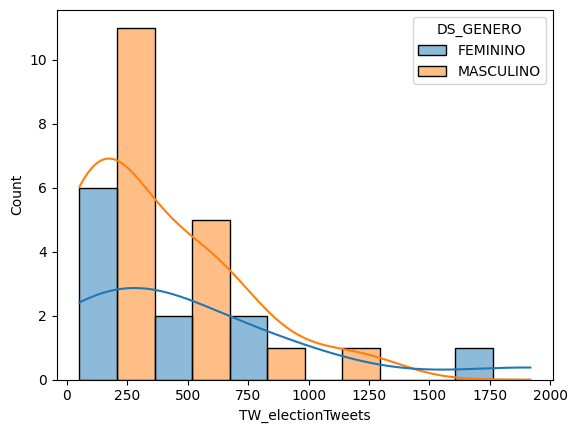

In [27]:
sns.histplot(
    data=twitter_df.loc[twitter_df["TW_electionTweets"] > 50],
    x="TW_electionTweets",
    hue="DS_GENERO",
    multiple="dodge",
    kde=True,
)


<Axes: xlabel='TW_followersCount', ylabel='Count'>

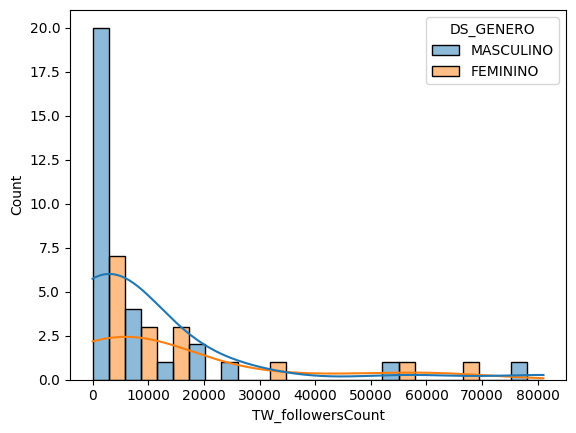

In [28]:
sns.histplot(
    data=twitter_df.loc[twitter_df["TW_followersCount"] < 100000],
    hue="DS_GENERO",
    x="TW_followersCount",
    multiple="dodge",
    kde=True,
)


<Axes: xlabel='TW_followersCount', ylabel='Count'>

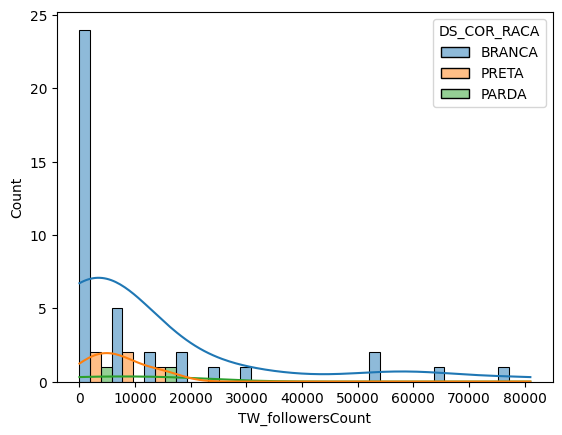

In [29]:
sns.histplot(
    data=twitter_df.loc[twitter_df["TW_followersCount"] < 100000],
    hue="DS_COR_RACA",
    x="TW_followersCount",
    multiple="dodge",
    kde=True,
)


# Exportação de dados

In [27]:
# Exportando dados scrapeados

output_path = "../data/processed/"
time_signature = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
output_file = f"sp_stdep_info-{time_signature}.csv"


# Para salvar os dados, descomente as linhas abaixo
# twitter_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)
